In Chapter 3, we looked at how to fine-tune a model on a given task. When we do that, we use the same tokenizer that the model was pretrained with — in these cases, using a tokenizer that was pretrained on a corpus from another domain or language is typically suboptimal. For example, a tokenizer that’s trained on an English corpus will perform poorly on a corpus of Japanese texts because the use of spaces and punctuation is very different in the two languages.

But what do we do when we want to train a model from scratch?

A pre-trained tokenizer will not be suitable if it has been trained on a corpus that is not similar to the one that you will use to train your model from scratch.

Dissimilarities can arise from


*   New langauge
*   New characters
*   New domain
*   New style




In [ ]:
from transformers import BertTokenizerFast
tokenizer = BertTokenizerFast.from_pretrained('huggingface-course/bert-base-uncased-tokenizer-without-normalizer')
text = "this tokenizer does not know accënts and CAPITAL LETTERS"
print(tokenizer.tokenize(text))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/894k [00:00<?, ?B/s]

['this', 'token', '##izer', 'does', 'not', 'know', '[UNK]', 'and', '[UNK]', '[UNK]']


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Remember the unknown token.

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained(
  'huggingface-course/bert-base-uncased-tokenizer-without-normalizer'
)
text = "the medical vocabulary is divided into many sub-token: paracetamol, phrayngitis"
print(tokenizer.tokenize(text))

['the', 'medical', 'vocabulary', 'is', 'divided', 'into', 'many', 'sub', '-', 'token', ':', 'para', '##ce', '##tam', '##ol', ',', 'ph', '##ray', '##ng', '##itis']


# Training a New Tokenizer (from an old one)

To train a new tokenizer:


1.   Gather a corpus of texts
2.   Choose a tokenizer architecture (or design a tokenizer architecture from scratch)
3.   Train the tokenizer on the corpus (fine-tuning)
4.   Save the result

*That's it!*



## Step 1

The `Datasets` library can help us assemble a corpus of Python source code. We’ll use the usual `load_dataset()` function to download and cache the [CodeSearchNet](https://huggingface.co/datasets/code-search-net/code_search_net) dataset

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.5 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


In [ ]:
from datasets import load_dataset

# This can take a few minutes to load, so grab a coffee or tea while you wait!
raw_datasets = load_dataset("code_search_net", "python")

code_search_net.py:   0%|          | 0.00/8.44k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/12.9k [00:00<?, ?B/s]

The repository for code_search_net contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/code_search_net.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


python.zip:   0%|          | 0.00/941M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/412178 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/22176 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/23107 [00:00<?, ? examples/s]

We can have a look at the training split to see which columns we have access to:

In [ ]:
raw_datasets["train"]

Dataset({
    features: ['repository_name', 'func_path_in_repository', 'func_name', 'whole_func_string', 'language', 'func_code_string', 'func_code_tokens', 'func_documentation_string', 'func_documentation_tokens', 'split_name', 'func_code_url'],
    num_rows: 412178
})

We can see the dataset separates docstrings from code and suggests a tokenization of both (plain text and code text). Here. we’ll just use the whole_func_string column to train our tokenizer. We can look at an example of one these functions by indexing into the train split:

In [ ]:
print(raw_datasets["train"][123456]["whole_func_string"])

def core_properties(self):
        """
        Instance of |CoreProperties| holding the read/write Dublin Core
        document properties for this presentation. Creates a default core
        properties part if one is not present (not common).
        """
        try:
            return self.part_related_by(RT.CORE_PROPERTIES)
        except KeyError:
            core_props = CorePropertiesPart.default()
            self.relate_to(core_props, RT.CORE_PROPERTIES)
            return core_props


Using a Python generator, we can avoid Python loading anything into memory until it’s actually necessary. To create such a generator, you just to need to replace the brackets with parentheses:

In [ ]:
def get_training_corpus():
    return (
        raw_datasets["train"][i : i + 1000]["whole_func_string"]
        for i in range(0, len(raw_datasets["train"]), 1000)
    )


training_corpus = get_training_corpus()

This line of code doesn’t fetch any elements of the dataset; it just creates an object you can use in a Python for loop. The texts will only be loaded when you need them (that is, when you’re at the step of the for loop that requires them), and only 1,000 texts at a time will be loaded. This way you won’t exhaust all your memory even if you are processing a huge dataset.

## Step 2

In [ ]:
from transformers import AutoTokenizer

old_tokenizer = AutoTokenizer.from_pretrained("gpt2")

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
example = '''def add_numbers(a, b):
    """Add the two numbers `a` and `b`."""
    return a + b'''

tokens = old_tokenizer.tokenize(example)
tokens

['def',
 'Ġadd',
 '_',
 'n',
 'umbers',
 '(',
 'a',
 ',',
 'Ġb',
 '):',
 'Ċ',
 'Ġ',
 'Ġ',
 'Ġ',
 'Ġ"""',
 'Add',
 'Ġthe',
 'Ġtwo',
 'Ġnumbers',
 'Ġ`',
 'a',
 '`',
 'Ġand',
 'Ġ`',
 'b',
 '`',
 '."',
 '""',
 'Ċ',
 'Ġ',
 'Ġ',
 'Ġ',
 'Ġreturn',
 'Ġa',
 'Ġ+',
 'Ġb']

This tokenizer has a few special symbols, like `Ġ` and `Ċ`, which denote spaces and newlines, respectively. As we can see, this is not too efficient: the tokenizer returns individual tokens for each space, when it could group together indentation levels (since having sets of four or eight spaces is going to be very common in code). It also split the function name a bit weirdly, not being used to seeing words with the `_` character.

## Step 3
The transformers library provides a easy to use method to train a tokenizer using a known architecture on a new corpus.

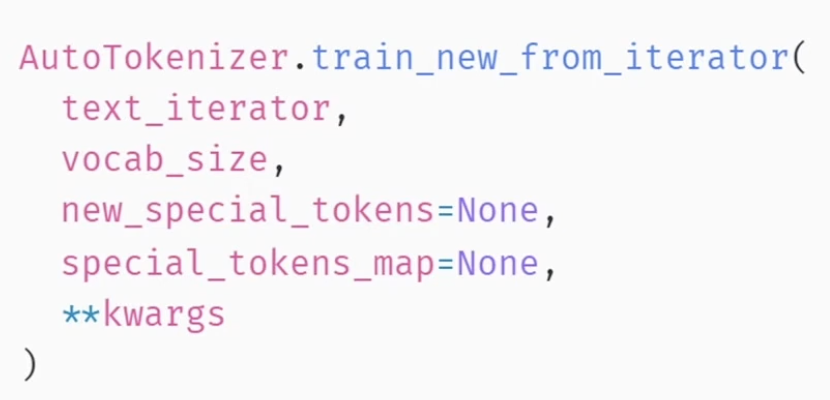

Let’s train a new tokenizer and see if it solves those issues. For this, we’ll use the method `train_new_from_iterator()`:

In [ ]:
tokenizer = old_tokenizer.train_new_from_iterator(training_corpus, 52000)

This command might take a bit of time if your corpus is very large, but for this dataset of 1.6 GB of texts it’s relatively fast.



In [ ]:
tokens = tokenizer.tokenize(example)
tokens

['def',
 'Ġadd',
 '_',
 'numbers',
 '(',
 'a',
 ',',
 'Ġb',
 '):',
 'ĊĠĠĠ',
 'Ġ"""',
 'Add',
 'Ġthe',
 'Ġtwo',
 'Ġnumbers',
 'Ġ`',
 'a',
 '`',
 'Ġand',
 'Ġ`',
 'b',
 '`."""',
 'ĊĠĠĠ',
 'Ġreturn',
 'Ġa',
 'Ġ+',
 'Ġb']

Here we again see the special symbols `Ġ` and `Ċ` that denote spaces and newlines, but we can also see that our tokenizer learned some tokens that are highly specific to a corpus of Python functions:

For example, there is a `ĊĠĠĠ` token that represents an indentation, and a `Ġ"""` token that represents the three quotes that start a docstring. The tokenizer also correctly split the function name on `_`. This is quite a compact representation; comparatively, using the plain English tokenizer on the same example will give us a longer sentence:

## Step 4

To make sure we can use it later, we need to save our new tokenizer.

In [ ]:
tokenizer.save_pretrained("code-search-net-tokenizer")

('code-search-net-tokenizer/tokenizer_config.json',
 'code-search-net-tokenizer/special_tokens_map.json',
 'code-search-net-tokenizer/vocab.json',
 'code-search-net-tokenizer/merges.txt',
 'code-search-net-tokenizer/added_tokens.json',
 'code-search-net-tokenizer/tokenizer.json')

# Tokenizer Components

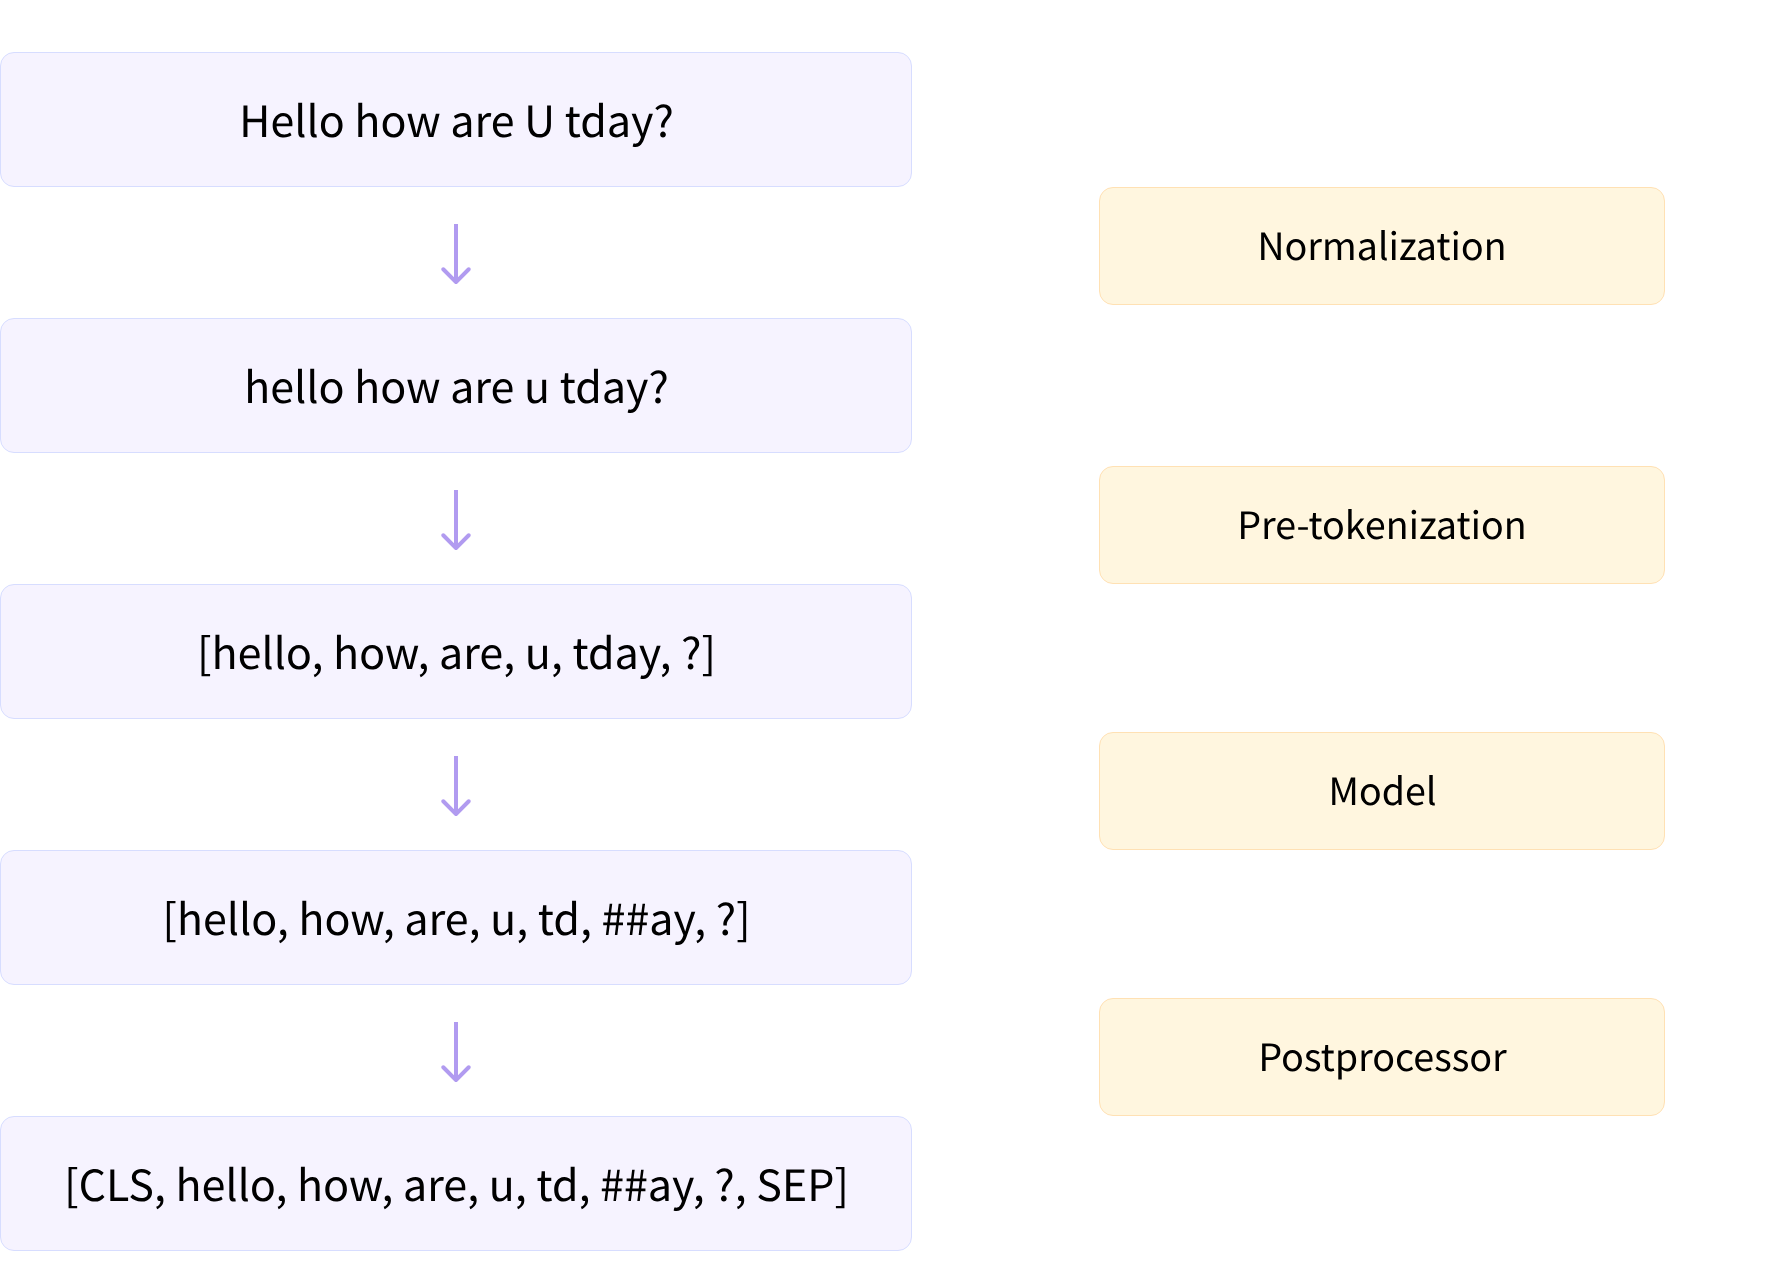

Before splitting a text into subtokens (according to its model), the tokenizer performs two steps: normalization and pre-tokenization.

## Normalization

The normalization step involves some general cleanup, such as removing needless whitespace, lowercasing, and/or removing accents. These are generally useless for the learning of the tokenization model.

In [ ]:
# viewing a normalizer for a tokenizer is not that easy - you have to access the tokenizer's generally abstracted backend
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

The `normalizer` attribute of the `tokenizer` object has a `normalize_str()` method that we can use to see how the normalization is performed:

In [ ]:
print(tokenizer.backend_tokenizer.normalizer.normalize_str("Héllò hôw are ü?"))

hello how are u?


## Pre-tokenization

In this step, rules are applied to realize a first split of the text.

Each tokinzer model will have slightly different rules, but they try to achieve the same thing more or less.

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str("Hello, how are     you?")

[('Hello', (0, 5)),
 (',', (5, 6)),
 ('how', (7, 10)),
 ('are', (11, 14)),
 ('you', (19, 22)),
 ('?', (22, 23))]

Notice how the tokenizer is already keeping track of the offsets. Here the tokenizer ignores the two spaces and replaces them with just one, but the offset jumps between are and you to account for that.

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str("Hello, how are    you?")

[('Hello', (0, 5)),
 (',', (5, 6)),
 ('Ġhow', (6, 10)),
 ('Ġare', (10, 14)),
 ('ĠĠĠ', (14, 17)),
 ('Ġyou', (17, 21)),
 ('?', (21, 22))]

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("albert-base-v1")
tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str("Hello, how are  you?")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

[('▁Hello,', (0, 6)),
 ('▁how', (7, 10)),
 ('▁are', (11, 14)),
 ('▁you?', (16, 20))]

The GPT-2 tokenizer it will split on whitespace and punctuation as well, but it will keep the spaces and replace them with a Ġ symbol, enabling it to recover the original spaces if we decode the tokens

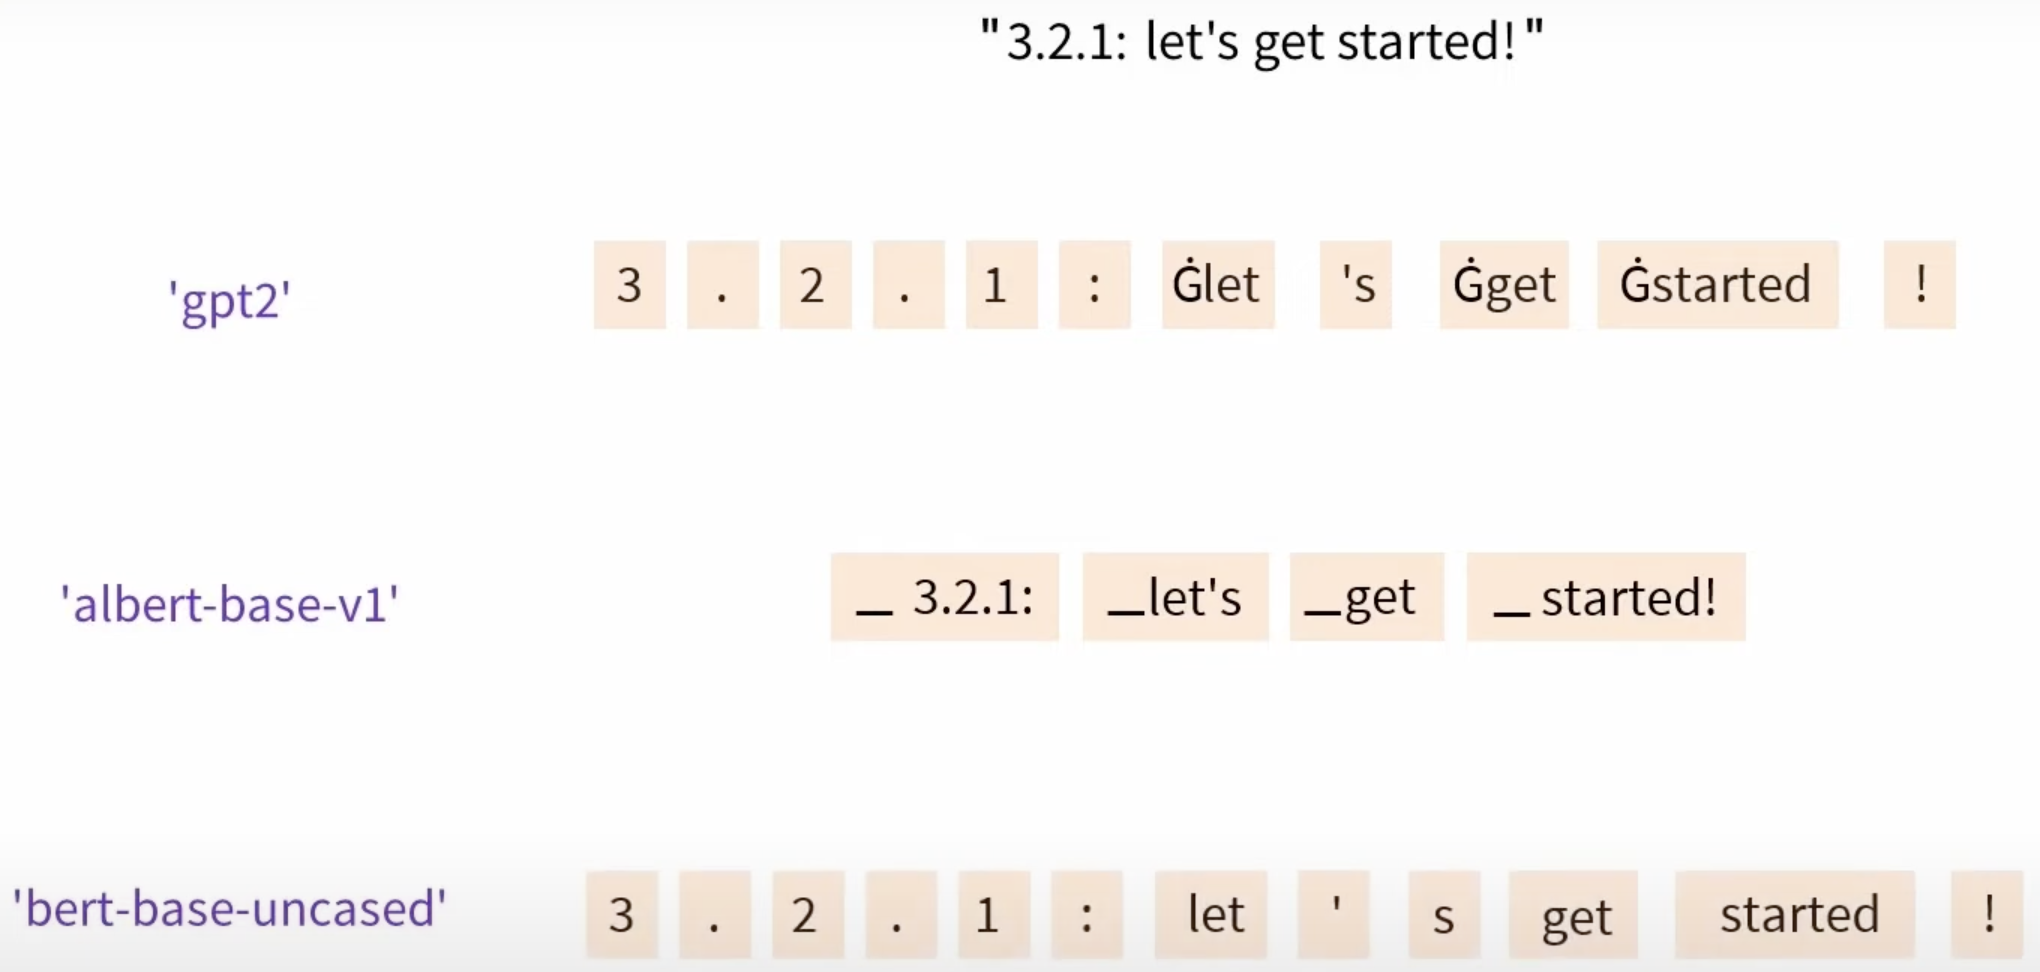

## Tokenization Model: Byte Pair Encoding

The basic idea behind BPE is to divide words into a seqeunce of "subword units" which are units that appear frequently in the reference corpus.
Happens only after normalization & pre-tokenization.

As a very simple example, let’s say our corpus uses these five words:
```sh
"hug", "pug", "pun", "bun", "hugs"
```

Let’s assume the words had the following frequencies:
```
("hug", 10), ("pug", 5), ("pun", 12), ("bun", 4), ("hugs", 5)
```

The base vocabulary will then be ```["b", "g", "h", "n", "p", "s", "u"]```.

After getting this base vocabulary, we add new tokens until the desired vocabulary size is reached by learning merges, which are rules to merge two elements of the existing vocabulary together into a new one. So, at the beginning these merges will create tokens with two characters, and then, as training progresses, longer subwords.

We start the training by splitting each word into characters (the ones that form our initial vocabulary) so we can see each word as a list of tokens:
```
("h" "u" "g", 10), ("p" "u" "g", 5), ("p" "u" "n", 12), ("b" "u" "n", 4), ("h" "u" "g" "s", 5)
```

Then we look at pairs. The pair ("h", "u") is present in the words "hug" and "hugs", so 15 times total in the corpus. It’s not the most frequent pair, though: that honor belongs to ("u", "g"), which is present in "hug", "pug", and "hugs", for a grand total of 20 times in the vocabulary.



Thus, the first merge rule learned by the tokenizer is ("u", "g") -> "ug", which means that "ug" will be added to the vocabulary, and the pair should be merged in all the words of the corpus. At the end of this stage, the vocabulary and corpus look like this:

```
Vocabulary: ["b", "g", "h", "n", "p", "s", "u", "ug"]
Corpus: ("h" "ug", 10), ("p" "ug", 5), ("p" "u" "n", 12), ("b" "u" "n", 4), ("h" "ug" "s", 5)
```

Next merge:

```
Vocabulary: ["b", "g", "h", "n", "p", "s", "u", "ug", "un"]
Corpus: ("h" "ug", 10), ("p" "ug", 5), ("p" "un", 12), ("b" "un", 4), ("h" "ug" "s", 5)
```

Next merge:

```
Vocabulary: ["b", "g", "h", "n", "p", "s", "u", "ug", "un", "hug"]
Corpus: ("hug", 10), ("p" "ug", 5), ("p" "un", 12), ("b" "un", 4), ("hug" "s", 5)
```

And we continue like this until we reach the desired vocabulary size.

## Tokenization Algorithm: WordPiece

WordPiece is the tokenization algorithm Google developed to pretrain BERT. It has since been reused in quite a few Transformer models based on BERT, such as DistilBERT, MobileBERT, Funnel Transformers, and MPNET. It’s very similar to BPE in terms of the training, but the actual tokenization is done differently.

Like BPE, WordPiece starts from a small vocabulary including the special tokens used by the model and the initial alphabet. Since it identifies subwords by adding a prefix (like ##), each word is initially split by adding that prefix to all the characters inside the word. So, for instance, "word" gets split like this:

```
w ##o ##r ##d
```


Then, again like BPE, WordPiece learns merge rules. The main difference is the way the pair to be merged is selected. Instead of selecting the most frequent pair, WordPiece computes a score for each pair, using the following formula:
```
score=(freq_of_pair)/(freq_of_first_element×freq_of_second_element)
```


Let’s look at the same vocabulary we used in the BPE training example:

```
("hug", 10), ("pug", 5), ("pun", 12), ("bun", 4), ("hugs", 5)
```

The splits here would be:

```
("h" "##u" "##g", 10), ("p" "##u" "##g", 5), ("p" "##u" "##n", 12), ("b" "##u" "##n", 4), ("h" "##u" "##g" "##s", 5)
```

so the initial vocabulary will be `["b", "h", "p", "##g", "##n", "##s", "##u"]` (if we forget about special tokens for now). The most frequent pair is `("##u", "##g")` (present 20 times), but the individual frequency of `"##u"` is very high, so its score is not the highest (it’s 1 / 36). All pairs with a `"##u"` actually have that same score (1 / 36), so the best score goes to the pair `("##g", "##s")` — the only one without a "##u" — at 1 / 20, and the first merge learned is `("##g", "##s") -> ("##gs")`.



Next merge:

```
Vocabulary: ["b", "g", "h", "n", "p", "s", "u", "gs"]
Corpus: ("h" "##u" "##g", 10), ("p" "##u" "##g", 5), ("p" "##u" "##n", 12), ("b" "##u" "##n", 4), ("h" "##u" "##gs", 5)
```

## Tokenization Algorithm: Unigram

Compared to BPE and WordPiece, Unigram works in the other direction: it starts from a big vocabulary and removes tokens from it until it reaches the desired vocabulary size.

At each step of the training, the Unigram algorithm computes a loss over the corpus given the current vocabulary. Then, for each symbol in the vocabulary, the algorithm computes how much the overall loss would increase if the symbol was removed, and looks for the symbols that would increase it the least. Those symbols have a lower effect on the overall loss over the corpus, so in a sense they are “less needed” and are the best candidates for removal.


Let’s stick to the same example:

```
("hug", 10), ("pug", 5), ("pun", 12), ("bun", 4), ("hugs", 5)
```

Here are the frequencies of all the possible subwords in the base vocabulary:

```
("h", 15) ("u", 36) ("g", 20) ("hu", 15) ("ug", 20) ("p", 17) ("pu", 17) ("n", 16)
("un", 16) ("b", 4) ("bu", 4) ("s", 5) ("hug", 15) ("gs", 5) ("ugs", 5)
```

So, the sum of all frequencies is 210, and the probability of the subword `"ug"` is thus 20/210.



The probability of a given token is its frequency (the number of times we find it) in the original corpus, divided by the sum of all frequencies of all tokens in the vocabulary (to make sure the probabilities sum up to 1). For instance, `"ug"` is present in `"hug"`, `"pug"`, and `"hugs"`, so it has a frequency of 20 in our corpus.



# So can we train a Tokenizer from scratch now?

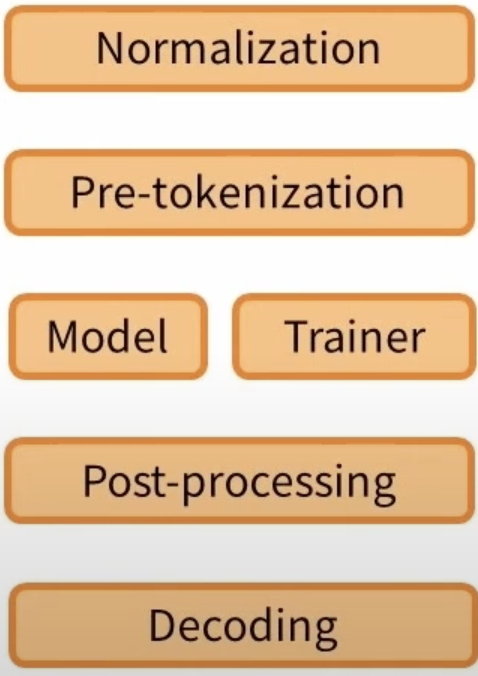

```python
from datasets import load_dataset
dataset = load_dataset("wikitext", name="wikitext-2-raw-vi", split="train")
```

```python
def get_training_corpus():
  for i in range(0, len(dataset), 1000):
    yield dataset[i : i + 1000]["text"]
```

```python
from tokenizers import Tokenizer, models, normalizers, pre_tokenizers, trainers, processors, decoders

tokenizer = Tokenizer(models.WordPiece(unk_token="[UNK]" ))

tokenizer.normalizer = normalizers.Sequence(I
	normalizers.Replace(Regex(r"I\pfOther}86[^\n\t\r]]"),""), normalizers.Replace(Regex(r"[\s]"), " "), normalizers.Lowercase), normalizers.NFD(), normalizers.StripAccents)
])

pre_tokenizer = pre_tokenizers.sequence([pre_tokenizers.WhitespaceSplit(), pre_tokenizers.Punctuation()])

special_tokens = ["[UNK]", " [PAD]", "[CLS]", "[SEP]", "[MASK]"]

trainer = trainers.WordPieceTrainer(vocab_size=25000, special_tokens=special_tokens)
tokenizer.train_from_iterator(get_training_corpus(), trainer=trainer)

cls_token_id = tokenizer.token_to_id("[CLS]")
sep_token_id = tokenizer.token_to_id("[SEP]")

tokenizer.post_processor = processors.TemplateProcessing(
	single=f"[CLS]:0 $A:0 [SEP]:0"
	pair=f" [CLS]:0 $A:0 [SEP]:0 $B:1 [SEP]:1",
	special_tokens-[("[CLS]", cls_token_id), ("[SEP]", sep_token_id)],
)
tokenizer.decoder = decoders.WordPiece(prefix="##")
```

# What are fast tokenizers?

Slow tokenizers are those written in Python inside the Transformers library, while the fast versions are the ones provided by Tokenizers, which are written in Rust. I

In [ ]:
from datasets import load_dataset

raw_datasets = load_dataset("glue", "mnli")
raw_datasets

README.md:   0%|          | 0.00/35.3k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/52.2M [00:00<?, ?B/s]

(…)alidation_matched-00000-of-00001.parquet:   0%|          | 0.00/1.21M [00:00<?, ?B/s]

(…)dation_mismatched-00000-of-00001.parquet:   0%|          | 0.00/1.25M [00:00<?, ?B/s]

test_matched-00000-of-00001.parquet:   0%|          | 0.00/1.22M [00:00<?, ?B/s]

test_mismatched-00000-of-00001.parquet:   0%|          | 0.00/1.26M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating validation_matched split:   0%|          | 0/9815 [00:00<?, ? examples/s]

Generating validation_mismatched split:   0%|          | 0/9832 [00:00<?, ? examples/s]

Generating test_matched split:   0%|          | 0/9796 [00:00<?, ? examples/s]

Generating test_mismatched split:   0%|          | 0/9847 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9847
    })
})

In [ ]:
from transformers import AutoTokenizer
fast_tokenizer = AutoTokenizer.from_pretrained( "bert-base-cased")

def tokenize_with_fast(examples):
  return fast_tokenizer(
      examples["premise"], examples["hypothesis"], truncation=True
    )

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [ ]:
slow_tokenizer = AutoTokenizer.from_pretrained("bert-base-cased", use_fast=False)
def tokenize_with_slow(examples):
  return fast_tokenizer(
      examples ["premise"], examples ["hypothesis"], truncation=True
      )

In [ ]:
%time tokenized_datasets = raw_datasets.map(tokenize_with_slow)

Map:   0%|          | 0/392702 [00:00<?, ? examples/s]

Map:   0%|          | 0/9815 [00:00<?, ? examples/s]

Map:   0%|          | 0/9832 [00:00<?, ? examples/s]

Map:   0%|          | 0/9796 [00:00<?, ? examples/s]

Map:   0%|          | 0/9847 [00:00<?, ? examples/s]

CPU times: user 3min 10s, sys: 1.98 s, total: 3min 12s
Wall time: 3min 18s


In [ ]:
%time tokenized_datasets = raw_datasets.map(tokenize_with_fast)

Map:   0%|          | 0/392702 [00:00<?, ? examples/s]

Map:   0%|          | 0/9815 [00:00<?, ? examples/s]

Map:   0%|          | 0/9832 [00:00<?, ? examples/s]

Map:   0%|          | 0/9796 [00:00<?, ? examples/s]

Map:   0%|          | 0/9847 [00:00<?, ? examples/s]

CPU times: user 3min 15s, sys: 1.97 s, total: 3min 17s
Wall time: 3min 24s


In [ ]:
%time tokenized_datasets = raw_datasets.map(tokenize_with_slow, batched=True)

Map:   0%|          | 0/392702 [00:00<?, ? examples/s]

Map:   0%|          | 0/9815 [00:00<?, ? examples/s]

Map:   0%|          | 0/9832 [00:00<?, ? examples/s]

Map:   0%|          | 0/9796 [00:00<?, ? examples/s]

Map:   0%|          | 0/9847 [00:00<?, ? examples/s]

CPU times: user 1min 59s, sys: 1.13 s, total: 2min
Wall time: 1min 26s


In [ ]:
%time tokenized_datasets = raw_datasets.map(tokenize_with_fast, batched=True)

Map:   0%|          | 0/392702 [00:00<?, ? examples/s]

Map:   0%|          | 0/9815 [00:00<?, ? examples/s]

Map:   0%|          | 0/9832 [00:00<?, ? examples/s]

Map:   0%|          | 0/9796 [00:00<?, ? examples/s]

Map:   0%|          | 0/9847 [00:00<?, ? examples/s]

CPU times: user 2min, sys: 1.17 s, total: 2min 1s
Wall time: 1min 30s


# Batch Encoding

The output of a tokenizer isn’t a simple Python dictionary; what we get is actually a special `BatchEncoding` object.

It’s a subclass of a dictionary, but with additional methods that are mostly used by fast tokenizers.

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
example = "My name is Sampurn and I work at GFG in India."
encoding = tokenizer(example)

In [ ]:
print(type(encoding))

<class 'transformers.tokenization_utils_base.BatchEncoding'>


Since the AutoTokenizer class picks a fast tokenizer by default, we can use the additional methods this BatchEncoding object provides.

In [ ]:
tokenizer.is_fast

True

Let’s see what a fast tokenizer enables us to do. First, we can access the tokens without having to convert the IDs back to tokens:



In [ ]:
encoding.tokens()

['[CLS]',
 'My',
 'name',
 'is',
 'Sam',
 '##pur',
 '##n',
 'and',
 'I',
 'work',
 'at',
 'G',
 '##F',
 '##G',
 'in',
 'India',
 '.',
 '[SEP]']

We can also use the word_ids() method to get the index of the word each token comes from:

In [ ]:
encoding.word_ids()

[None, 0, 1, 2, 3, 3, 3, 4, 5, 6, 7, 8, 8, 8, 9, 10, 11, None]

Fast Tokenizers even keep track of each character span in the original text that gave each token:

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
example = "My name is Sampurn and I work at GFG in India."
encoding = tokenizer(example, return_offsets_mapping=True)

print(encoding.tokens())
print(encoding["offset_mapping"])

['[CLS]', 'My', 'name', 'is', 'Sam', '##pur', '##n', 'and', 'I', 'work', 'at', 'G', '##F', '##G', 'in', 'India', '.', '[SEP]']
[(0, 0), (0, 2), (3, 7), (8, 10), (11, 14), (14, 17), (17, 18), (19, 22), (23, 24), (25, 29), (30, 32), (33, 34), (34, 35), (35, 36), (37, 39), (40, 45), (45, 46), (0, 0)]


# Inside the Token Classification Pipeline

In Chapter 1 we got our first taste of applying NER — where the task is to identify which parts of the text correspond to entities like persons, locations, or organizations — with the Transformers `pipeline()` function.

Then, in Chapter 2, we saw how a pipeline groups together the three stages necessary to get the predictions from a raw text: tokenization, passing the inputs through the model, and post-processing.

In [ ]:
# The model used by default is dbmdz/bert-large-cased-finetuned-conll03-english; it performs NER on sentences
from transformers import pipeline

token_classifier = pipeline("token-classification")
token_classifier("My name is Sampurn and I work at GFG in India.")

No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/998 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


[{'entity': 'I-PER',
  'score': 0.9994172,
  'index': 4,
  'word': 'Sam',
  'start': 11,
  'end': 14},
 {'entity': 'I-PER',
  'score': 0.9977697,
  'index': 5,
  'word': '##pur',
  'start': 14,
  'end': 17},
 {'entity': 'I-PER',
  'score': 0.99787784,
  'index': 6,
  'word': '##n',
  'start': 17,
  'end': 18},
 {'entity': 'I-ORG',
  'score': 0.9977914,
  'index': 11,
  'word': 'G',
  'start': 33,
  'end': 34},
 {'entity': 'I-ORG',
  'score': 0.9920517,
  'index': 12,
  'word': '##F',
  'start': 34,
  'end': 35},
 {'entity': 'I-ORG',
  'score': 0.9862322,
  'index': 13,
  'word': '##G',
  'start': 35,
  'end': 36},
 {'entity': 'I-LOC',
  'score': 0.9997893,
  'index': 15,
  'word': 'India',
  'start': 40,
  'end': 45}]

We can also ask the pipeline to group together the tokens that correspond to the same entity:

In [ ]:
from transformers import pipeline

token_classifier = pipeline("token-classification", aggregation_strategy="simple")
token_classifier("My name is Sampurn and I work at GFG in India.")

No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[{'entity_group': 'PER',
  'score': 0.9983549,
  'word': 'Sampurn',
  'start': 11,
  'end': 18},
 {'entity_group': 'ORG',
  'score': 0.99202514,
  'word': 'GFG',
  'start': 33,
  'end': 36},
 {'entity_group': 'LOC',
  'score': 0.9997893,
  'word': 'India',
  'start': 40,
  'end': 45}]

The aggregation_strategy picked will change the scores computed for each grouped entity. With "simple" the score is just the mean of the scores of each token in the given entity.

## Let's look at the process in more detail

First we need to tokenize our input and pass it through the model.

In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification

model_checkpoint = "dbmdz/bert-large-cased-finetuned-conll03-english"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint)

example = "My name is Sampurn and I work at GFG in India."
inputs = tokenizer(example, return_tensors="pt")
outputs = model(**inputs)

Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Since we’re using AutoModelForTokenClassification here, we get one set of logits for each token in the input sequence:



In [ ]:
print(inputs["input_ids"].shape)
print(outputs.logits.shape)

torch.Size([1, 18])
torch.Size([1, 18, 9])


We have a batch with 1 sequence of 18 tokens and the model has 9 different labels, so the output of the model has a shape of 1 x 18 x 9. Like for the text classification pipeline, we use a softmax function to convert those logits to probabilities, and we take the argmax to get predictions (note that we can take the argmax on the logits because the softmax does not change the order):

In [ ]:
import torch

probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)[0].tolist()
predictions = outputs.logits.argmax(dim=-1)[0].tolist()
print(predictions)

[0, 0, 0, 0, 4, 4, 4, 0, 0, 0, 0, 6, 6, 6, 0, 8, 0, 0]


The `model.config.id2label` attribute contains the mapping of indexes to labels that we can use to make sense of the predictions:



In [ ]:
model.config.id2label

{0: 'O',
 1: 'B-MISC',
 2: 'I-MISC',
 3: 'B-PER',
 4: 'I-PER',
 5: 'B-ORG',
 6: 'I-ORG',
 7: 'B-LOC',
 8: 'I-LOC'}

There are 9 labels: O is the label for the tokens that are not in any named entity (it stands for “outside”), and we then have two labels for each type of entity (miscellaneous, person, organization, and location). The label B-XXX indicates the token is at the beginning of an entity XXX and the label I-XXX indicates the token is inside the entity XXX. For instance, in the current example we would expect our model to classify the token Sam as B-PER (beginning of a person entity) and the tokens ##pur, and ##n as I-PER (inside a person entity).

With this mapping, we are ready to reproduce (almost entirely) the results of the first pipeline — we can just grab the score and label of each token that was not classified as O:



In [ ]:
results = []
tokens = inputs.tokens()

for idx, pred in enumerate(predictions):
    label = model.config.id2label[pred]
    if label != "O":
        results.append(
            {"entity": label, "score": probabilities[idx][pred], "word": tokens[idx]}
        )

print(results)

[{'entity': 'I-PER', 'score': 0.9994170665740967, 'word': 'Sam'}, {'entity': 'I-PER', 'score': 0.997769832611084, 'word': '##pur'}, {'entity': 'I-PER', 'score': 0.997877836227417, 'word': '##n'}, {'entity': 'I-ORG', 'score': 0.9977914094924927, 'word': 'G'}, {'entity': 'I-ORG', 'score': 0.9920517206192017, 'word': '##F'}, {'entity': 'I-ORG', 'score': 0.9862322211265564, 'word': '##G'}, {'entity': 'I-LOC', 'score': 0.999789297580719, 'word': 'India'}]


This is very similar to what we had before, with one exception: the pipeline also gave us information about the start and end of each entity in the original sentence. This is where our offset mapping will come into play. To get the offsets, we just have to set return_offsets_mapping=True when we apply the tokenizer to our inputs:

In [ ]:
inputs_with_offsets = tokenizer(example, return_offsets_mapping=True)
inputs_with_offsets["offset_mapping"]

[(0, 0),
 (0, 2),
 (3, 7),
 (8, 10),
 (11, 14),
 (14, 17),
 (17, 18),
 (19, 22),
 (23, 24),
 (25, 29),
 (30, 32),
 (33, 34),
 (34, 35),
 (35, 36),
 (37, 39),
 (40, 45),
 (45, 46),
 (0, 0)]

Using this, we can now complete the previous results:


In [ ]:
results = []
inputs_with_offsets = tokenizer(example, return_offsets_mapping=True)
tokens = inputs_with_offsets.tokens()
offsets = inputs_with_offsets["offset_mapping"]

for idx, pred in enumerate(predictions):
    label = model.config.id2label[pred]
    if label != "O":
        start, end = offsets[idx]
        results.append(
            {
                "entity": label,
                "score": probabilities[idx][pred],
                "word": tokens[idx],
                "start": start,
                "end": end,
            }
        )

print(results)

[{'entity': 'I-PER', 'score': 0.9994170665740967, 'word': 'Sam', 'start': 11, 'end': 14}, {'entity': 'I-PER', 'score': 0.997769832611084, 'word': '##pur', 'start': 14, 'end': 17}, {'entity': 'I-PER', 'score': 0.997877836227417, 'word': '##n', 'start': 17, 'end': 18}, {'entity': 'I-ORG', 'score': 0.9977914094924927, 'word': 'G', 'start': 33, 'end': 34}, {'entity': 'I-ORG', 'score': 0.9920517206192017, 'word': '##F', 'start': 34, 'end': 35}, {'entity': 'I-ORG', 'score': 0.9862322211265564, 'word': '##G', 'start': 35, 'end': 36}, {'entity': 'I-LOC', 'score': 0.999789297580719, 'word': 'India', 'start': 40, 'end': 45}]


To write the code that post-processes the predictions while grouping entities, we will group together entities that are consecutive and labeled with I-XXX, except for the first one, which can be labeled as B-XXX or I-XXX (so, we stop grouping an entity when we get a O, a new type of entity, or a B-XXX that tells us an entity of the same type is starting):

In [ ]:
import numpy as np

results = []
inputs_with_offsets = tokenizer(example, return_offsets_mapping=True)
tokens = inputs_with_offsets.tokens()
offsets = inputs_with_offsets["offset_mapping"]

idx = 0
while idx < len(predictions):
    pred = predictions[idx]
    label = model.config.id2label[pred]
    if label != "O":
        # Remove the B- or I-
        label = label[2:]
        start, _ = offsets[idx]

        # Grab all the tokens labeled with I-label
        all_scores = []
        while (
            idx < len(predictions)
            and model.config.id2label[predictions[idx]] == f"I-{label}"
        ):
            all_scores.append(probabilities[idx][pred])
            _, end = offsets[idx]
            idx += 1

        # The score is the mean of all the scores of the tokens in that grouped entity
        score = np.mean(all_scores).item()
        word = example[start:end]
        results.append(
            {
                "entity_group": label,
                "score": score,
                "word": word,
                "start": start,
                "end": end,
            }
        )
    idx += 1

print(results)

[{'entity_group': 'PER', 'score': 0.9983549118041992, 'word': 'Sampurn', 'start': 11, 'end': 18}, {'entity_group': 'ORG', 'score': 0.9920251170794169, 'word': 'GFG', 'start': 33, 'end': 36}, {'entity_group': 'LOC', 'score': 0.999789297580719, 'word': 'India', 'start': 40, 'end': 45}]


# Fast Tokenizers in the Question-Answer Pipeline

As we saw in Chapter 1, we can use the question-answering pipeline like this to get the answer to a question:

In [ ]:
from transformers import pipeline

question_answerer = pipeline("question-answering")
context = """
🤗 Transformers is backed by the three most popular deep learning libraries — Jax, PyTorch, and TensorFlow — with a seamless integration
between them. It's straightforward to train your models with one before loading them for inference with the other.
"""
question = "Which deep learning libraries back 🤗 Transformers?"
question_answerer(question=question, context=context)

No model was supplied, defaulted to distilbert/distilbert-base-cased-distilled-squad and revision 626af31 (https://huggingface.co/distilbert/distilbert-base-cased-distilled-squad).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/473 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/261M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

{'score': 0.98026043176651,
 'start': 78,
 'end': 106,
 'answer': 'Jax, PyTorch, and TensorFlow'}

Unlike the other pipelines, which can truncate and split texts that are longer than the maximum length accepted by the model (and thus may miss information at the end of a document), this pipeline has to deal with very long contexts and will return the answer to the question even if it’s at the end:

In [ ]:
long_context = """
🤗 Transformers: State of the Art NLP

🤗 Transformers provides thousands of pretrained models to perform tasks on texts such as classification, information extraction,
question answering, summarization, translation, text generation and more in over 100 languages.
Its aim is to make cutting-edge NLP easier to use for everyone.

🤗 Transformers provides APIs to quickly download and use those pretrained models on a given text, fine-tune them on your own datasets and
then share them with the community on our model hub. At the same time, each python module defining an architecture is fully standalone and
can be modified to enable quick research experiments.

Why should I use transformers?

1. Easy-to-use state-of-the-art models:
  - High performance on NLU and NLG tasks.
  - Low barrier to entry for educators and practitioners.
  - Few user-facing abstractions with just three classes to learn.
  - A unified API for using all our pretrained models.
  - Lower compute costs, smaller carbon footprint:

2. Researchers can share trained models instead of always retraining.
  - Practitioners can reduce compute time and production costs.
  - Dozens of architectures with over 10,000 pretrained models, some in more than 100 languages.

3. Choose the right framework for every part of a model's lifetime:
  - Train state-of-the-art models in 3 lines of code.
  - Move a single model between TF2.0/PyTorch frameworks at will.
  - Seamlessly pick the right framework for training, evaluation and production.

4. Easily customize a model or an example to your needs:
  - We provide examples for each architecture to reproduce the results published by its original authors.
  - Model internals are exposed as consistently as possible.
  - Model files can be used independently of the library for quick experiments.

🤗 Transformers is backed by the three most popular deep learning libraries — Jax, PyTorch and TensorFlow — with a seamless integration
between them. It's straightforward to train your models with one before loading them for inference with the other.
"""
question_answerer(question=question, context=long_context)

{'score': 0.9714871048927307,
 'start': 1892,
 'end': 1919,
 'answer': 'Jax, PyTorch and TensorFlow'}

Like with any other pipeline, we start by tokenizing our input and then send it through the model. The checkpoint used by default for the question-answering pipeline is distilbert-base-cased-distilled-squad (the “squad” in the name comes from the dataset on which the model was fine-tuned; we’ll talk more about the SQuAD dataset in Chapter 7). Note that we tokenize the question and the context as a pair, with the question first:

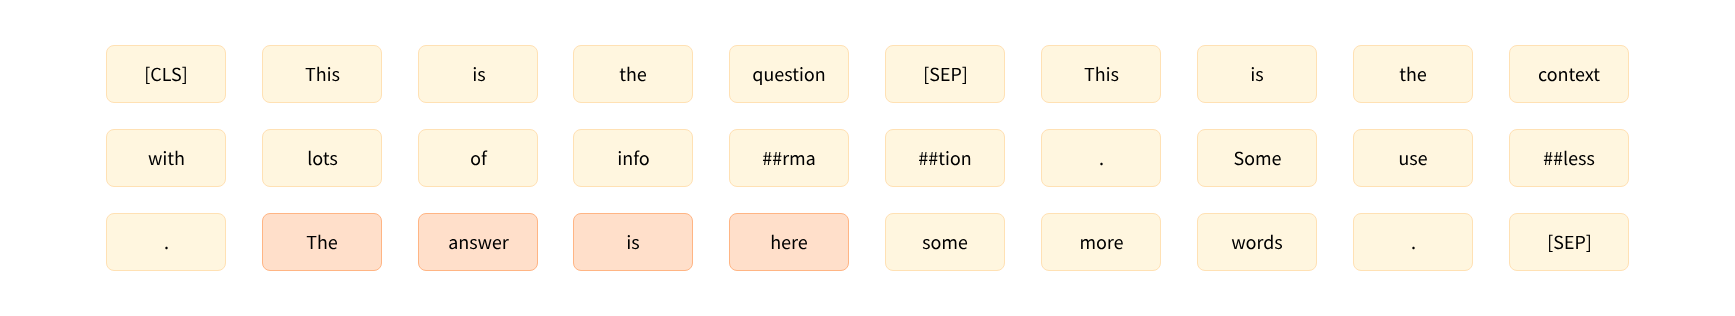

In [ ]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering

model_checkpoint = "distilbert-base-cased-distilled-squad"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

inputs = tokenizer(question, context, return_tensors="pt")
outputs = model(**inputs)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/473 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/261M [00:00<?, ?B/s]

Models for question answering work a little differently from the models we’ve seen up to now. The model has been trained to predict the index of the token starting the answer (here 21) and the index of the token where the answer ends (here 24). This is why those models don’t return one tensor of logits but two: one for the logits corresponding to the start token of the answer, and one for the logits corresponding to the end token of the answer.

In [ ]:
start_logits = outputs.start_logits
end_logits = outputs.end_logits
print(start_logits.shape, end_logits.shape)

torch.Size([1, 67]) torch.Size([1, 67])


To convert these logits into probabilities, we will apply a softmax function — but before that, we need to make sure we mask the indices that are not part of the context. Our input is [CLS] question [SEP] context [SEP], so we need to mask the tokens of the question as well as the [SEP] token.

In [ ]:
import torch

sequence_ids = inputs.sequence_ids()
# Mask everything apart from the tokens of the context
mask = [i != 1 for i in sequence_ids]
# Unmask the [CLS] token
mask[0] = False
mask = torch.tensor(mask)[None]

start_logits[mask] = -10000
end_logits[mask] = -10000

Now that we have properly masked the logits corresponding to positions we don’t want to predict, we can apply the softmax:

In [ ]:
start_probabilities = torch.nn.functional.softmax(start_logits, dim=-1)[0]
end_probabilities = torch.nn.functional.softmax(end_logits, dim=-1)[0]

An answer is a pair of start and end positions:

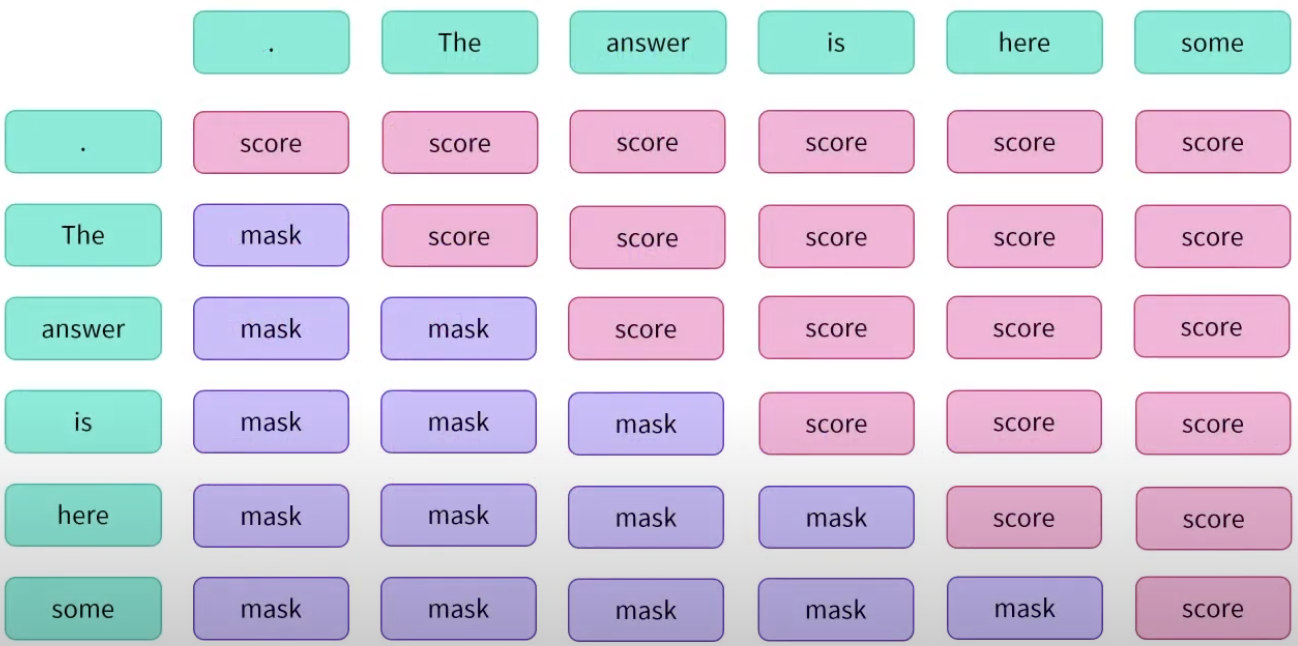

In [ ]:
# Reshape the start probabilities tensor from shape (sequence_length,) to (sequence_length, 1)
# by adding a new axis at position 1 using [:, None]. This transforms it into a column vector.
# Similarly, reshape the end probabilities tensor from shape (sequence_length,) to (1, sequence_length)
# by adding a new axis at position 0 using [None, :], transforming it into a row vector.
# Perform element-wise multiplication between the column vector and row vector to compute a
# (sequence_length, sequence_length) matrix of scores.
# Each element scores[i, j] represents the joint probability of the token at position i being
# the start of the answer span and the token at position j being the end of the answer span.
scores = start_probabilities[:, None] * end_probabilities[None, :]

# Apply the torch.triu (upper triangular) function to the scores matrix to zero out all elements
# where the end position is before the start position (i.e., where j < i). This ensures that only
# valid spans where the start index is less than or equal to the end index are considered.
scores = torch.triu(scores)

# Flatten the scores matrix into a one-dimensional tensor and use argmax to find the index of the
# maximum score. The argmax function returns the index of the highest value in the flattened tensor.
# The .item() method converts the resulting tensor containing a single value into a Python integer.
max_index = scores.argmax().item()

# Calculate the start index of the answer span by performing integer division (floor division) of
# max_index by the number of columns in the scores matrix (scores.shape[1], which is sequence_length).
# This retrieves the row index corresponding to the maximum score in the original 2D scores matrix.
start_index = max_index // scores.shape[1]

# Calculate the end index of the answer span by taking the modulus of max_index with the number of
# columns in the scores matrix. This retrieves the column index corresponding to the maximum score
# in the original 2D scores matrix.
end_index = max_index % scores.shape[1]

# Print the maximum score from the scores matrix corresponding to the best start and end indices.
# This value represents the highest joint probability of any valid answer span in the context.
print(scores[start_index, end_index])

# Use the tokenizer to encode the question and context into input IDs suitable for the model.
# Set return_offsets_mapping=True to obtain a mapping from each token to its corresponding
# character offsets in the original context text. The tokenizer outputs a dictionary containing
# various elements, including 'offset_mapping'.
inputs_with_offsets = tokenizer(question, context, return_offsets_mapping=True)

# Extract the 'offset_mapping' from the tokenizer output, which is a list of tuples.
# Each tuple consists of (start_char, end_char) positions indicating the span of each token
# in terms of character positions within the original context text.
offsets = inputs_with_offsets["offset_mapping"]

# Retrieve the character start position of the token at the calculated start_index.
# The offset at offsets[start_index] is a tuple (start_char, end_char). We extract start_char
# and ignore end_char by assigning it to '_', which is a common convention for unused variables.
start_char, _ = offsets[start_index]

# Retrieve the character end position of the token at the calculated end_index.
# Similarly, we extract end_char and ignore start_char by assigning it to '_'.
_, end_char = offsets[end_index]

# Extract the predicted answer text from the context by slicing the context string from
# start_char to end_char. This gives us the substring that spans the predicted answer.
answer = context[start_char:end_char]

# Create a dictionary to store the result, including:
# - "answer": the extracted answer text.
# - "start": the character start position of the answer in the context.
# - "end": the character end position of the answer in the context.
# - "score": the maximum score corresponding to the predicted answer span.
result = {
    "answer": answer,
    "start": start_char,
    "end": end_char,
    "score": scores[start_index, end_index],
}

# Print the result dictionary, which contains the predicted answer and related information.
# This output can be used for evaluation or further processing.
print(result)

tensor(0.9803, grad_fn=<SelectBackward0>)
{'answer': 'Jax, PyTorch, and TensorFlow', 'start': 78, 'end': 106, 'score': tensor(0.9803, grad_fn=<SelectBackward0>)}


If we try to tokenize the question and long context we used as an example previously, we’ll get a number of tokens higher than the maximum length used in the question-answering pipeline (which is 384):

In [ ]:
inputs = tokenizer(question, long_context)
print(len(inputs["input_ids"]))

461


So, we’ll need to truncate our inputs at that maximum length?

Or, to fix this, the question-answering pipeline allows us to split the context into smaller chunks, specifying the maximum length. To make sure we don’t split the context at exactly the wrong place to make it possible to find the answer, it also includes some overlap between the chunks.

In [ ]:
# Tokenize the question and long context with specified parameters
inputs = tokenizer(
    question,                  # The question text to be tokenized
    long_context,              # The context text to be tokenized
    stride=128,                # Overlap tokens by 128 positions between chunks for long contexts
    max_length=384,            # Maximum length of each tokenized input chunk
    padding="longest",         # Pad all sequences to the length of the longest sequence
    truncation="only_second",  # Truncate only the context (second sequence) if it exceeds max_length
    return_overflowing_tokens=True,  # Return information about overflow when splitting into chunks
    return_offsets_mapping=True,     # Return mapping of tokens to their original character positions
)